In [1]:
import os
import random

import cv2
from keras.applications import EfficientNetB0
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import layers

In [3]:
IMG_PATH = "Classification/images"
IMG_SIZE = 224

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    IMG_PATH,
    labels="inferred",
    label_mode="binary",
    class_names=None,
    color_mode="rgb",
    batch_size=4,
    image_size=(256, 256),
    shuffle=True,
    seed=42,
    validation_split=0.4,
    subset="training",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 286 files belonging to 2 classes.
Using 172 files for training.


In [5]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    IMG_PATH,
    labels="inferred",
    label_mode="binary",
    class_names=None,
    color_mode="rgb",
    batch_size=4,
    image_size=(256, 256),
    shuffle=True,
    seed=42,
    validation_split=0.4,
    subset="validation",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 286 files belonging to 2 classes.
Using 114 files for validation.


In [5]:
base_model = EfficientNetB0(
    weights="Classification/efficientnetb0_notop.h5", include_top=False
)
base_model.trainable = False

In [6]:
inputs = layers.Input(shape=(None, None, 3))
x = layers.Resizing(height=IMG_SIZE, width=IMG_SIZE)(inputs)
x = tf.keras.layers.RandomFlip(mode="horizontal_and_vertical")(x)
x = tf.keras.layers.RandomRotation(0.08)(x)
x = tf.keras.layers.RandomBrightness(0.07)(x)
x = tf.keras.layers.RandomContrast(0.05)(x)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(64)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1)(x)
x = layers.Activation("sigmoid")(x)
model = Model(inputs=inputs, outputs=x)

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 224, 224, 3)      0         
 tion)                                                           
                                                                 
 random_brightness (RandomBr  (None, 224, 224, 3)      0         
 ightness)                                                       
                                                                 
 random_contrast (RandomCont  (None, 224, 224, 3)      0     

In [8]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)

In [9]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(patience=6),
    tf.keras.callbacks.EarlyStopping(patience=13, restore_best_weights=True),
    tf.keras.callbacks.TensorBoard(
        "./logs",
        write_graph=True,
        write_images=True,
        update_freq="batch",
    ),
]

In [10]:
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

In [11]:
hist = model.fit(
    train_ds, epochs=100, validation_data=test_ds, verbose=1, callbacks=callbacks
)

Epoch 1/100
43/43 [==============================] - 12s 87ms/step - loss: 0.4247 - accuracy: 0.8023 - val_loss: 1.0332 - val_accuracy: 0.7982 - lr: 0.0100
Epoch 2/100
43/43 [==============================] - 2s 56ms/step - loss: 0.2954 - accuracy: 0.8779 - val_loss: 0.6057 - val_accuracy: 0.8070 - lr: 0.0100
Epoch 3/100
43/43 [==============================] - 2s 57ms/step - loss: 0.2448 - accuracy: 0.8953 - val_loss: 0.3035 - val_accuracy: 0.8684 - lr: 0.0100
Epoch 4/100
43/43 [==============================] - 2s 56ms/step - loss: 0.2208 - accuracy: 0.9360 - val_loss: 0.3836 - val_accuracy: 0.8772 - lr: 0.0100
Epoch 5/100
43/43 [==============================] - 2s 57ms/step - loss: 0.2345 - accuracy: 0.9128 - val_loss: 0.2908 - val_accuracy: 0.8684 - lr: 0.0100
Epoch 6/100
43/43 [==============================] - 2s 56ms/step - loss: 0.2156 - accuracy: 0.8953 - val_loss: 0.3435 - val_accuracy: 0.8509 - lr: 0.0100
Epoch 7/100
43/43 [==============================] - 2s 56ms/step - l

In [12]:
model.trainable = True

In [13]:
for layer in model.layers[6].layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 224, 224, 3)      0         
 tion)                                                           
                                                                 
 random_brightness (RandomBr  (None, 224, 224, 3)      0         
 ightness)                                                       
                                                                 
 random_contrast (RandomCont  (None, 224, 224, 3)      0     

In [15]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

In [16]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(patience=6),
    tf.keras.callbacks.EarlyStopping(patience=13, restore_best_weights=True),
    tf.keras.callbacks.TensorBoard(
        "./logs",
        write_graph=True,
        write_images=True,
        update_freq="batch",
    ),
]

In [17]:
hist = model.fit(
    train_ds,
    epochs=200,
    validation_data=test_ds,
    verbose=1,
    callbacks=callbacks,
    initial_epoch=len(hist.epoch),
)

Epoch 38/200
43/43 [==============================] - 13s 127ms/step - loss: 0.2991 - accuracy: 0.8953 - val_loss: 1.1867 - val_accuracy: 0.5263 - lr: 1.0000e-04
Epoch 39/200
43/43 [==============================] - 4s 102ms/step - loss: 0.3768 - accuracy: 0.8721 - val_loss: 0.2763 - val_accuracy: 0.8947 - lr: 1.0000e-04
Epoch 40/200
43/43 [==============================] - 4s 102ms/step - loss: 0.2541 - accuracy: 0.8953 - val_loss: 0.2312 - val_accuracy: 0.9298 - lr: 1.0000e-04
Epoch 41/200
43/43 [==============================] - 4s 101ms/step - loss: 0.2210 - accuracy: 0.9128 - val_loss: 0.2392 - val_accuracy: 0.8772 - lr: 1.0000e-04
Epoch 42/200
43/43 [==============================] - 4s 100ms/step - loss: 0.2223 - accuracy: 0.9070 - val_loss: 0.9297 - val_accuracy: 0.7807 - lr: 1.0000e-04
Epoch 43/200
43/43 [==============================] - 4s 104ms/step - loss: 0.2396 - accuracy: 0.8953 - val_loss: 0.3730 - val_accuracy: 0.8772 - lr: 1.0000e-04
Epoch 44/200
43/43 [=============

In [23]:
model.evaluate(test_ds)

29/29 [==============================] - 1s 18ms/step - loss: 0.1295 - accuracy: 0.9386


[0.12954846024513245, 0.9385964870452881]

In [18]:
model.trainable = False

In [19]:
for folder in ["harvest1", "notharvest0"]:
    IMAGE_PATHS = [
        os.path.join("Classification", "images", folder, file)
        for file in os.listdir(os.path.join("Classification", "images", folder))
        if file.endswith(".jpg")
    ]
    for image in random.choices(IMAGE_PATHS, k=4):
        img = cv2.imread(image)[:, :, ::-1]
        img = img[np.newaxis, ...]
        result = model.predict(img, verbose=0)[0][0] < 0.5
        print(result)

True
True
True
True
False
False
False
False


In [20]:
model.save("classify_model", include_optimizer=False)

INFO:tensorflow:Assets written to: classify_model\assets


INFO:tensorflow:Assets written to: classify_model\assets


In [2]:
new_model = tf.keras.models.load_model("classify_model")

In [6]:
for folder in ["harvest1", "notharvest0"]:
    IMAGE_PATHS = [
        os.path.join("Classification", "images", folder, file)
        for file in os.listdir(os.path.join("Classification", "images", folder))
        if file.endswith(".jpg")
    ]
    for image in random.choices(IMAGE_PATHS, k=4):
        img = cv2.imread(image)[:, :, ::-1]
        img = img[np.newaxis, ...]
        result = new_model.predict(img, verbose=0)[0][0] < 0.5
        print(result)

True
True
True
True
False
False
False
False


In [19]:
y_pred = np.array([])
y_true = np.array([])
y_score = np.array([])
for x, y in test_ds:
    score = new_model.predict(x)
    y_score = np.append(y_score, (score))
    y_pred = np.append(y_pred, (score > 0.5).astype(np.int))
    y_true = np.append(y_true, (y.numpy().astype(np.int)))

1/1 [==============================] - 0s 23ms/step


C:\Users\RYZEN\AppData\Local\Temp\ipykernel_11304\3773531966.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pred = np.append(y_pred,(score>0.5).astype(np.int))
C:\Users\RYZEN\AppData\Local\Temp\ipykernel_11304\3773531966.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, chec

1/1 [==============================] - 0s 19ms/step


In [29]:
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, roc_curve

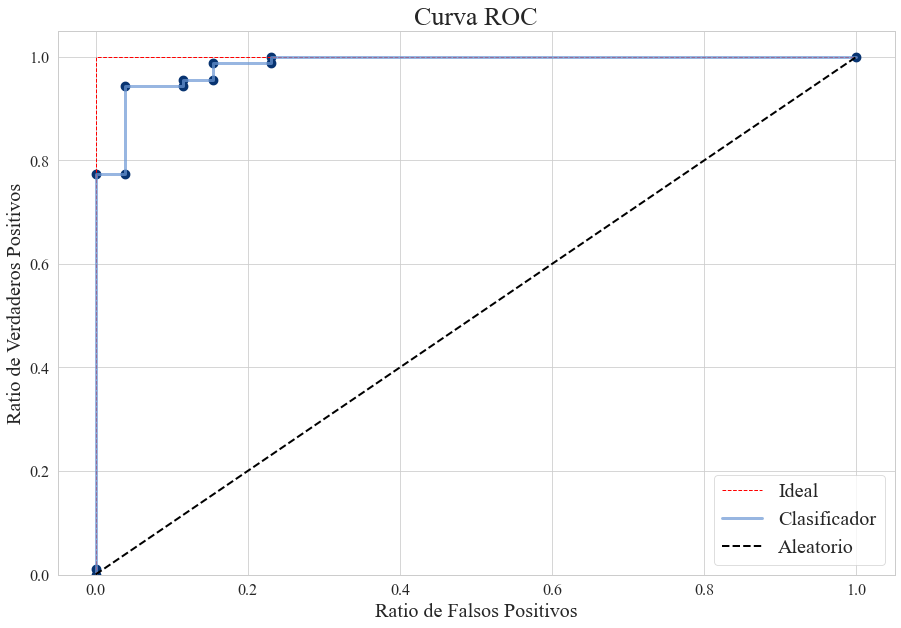

In [94]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

plt.rcParams["font.family"] = "Times New Roman"
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_true, y_score)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(15, 10))
plt.scatter(fpr[1], tpr[1],color=(8/255,52/255,113/255,1),linewidth=5)
plt.plot((0,0,1),(0,1,1),"r--",linewidth=1,label="Ideal")
plt.plot(fpr[1], tpr[1],color=(108/255,152/255,213/255,0.7),linewidth=3,label="Clasificador")
plt.plot((0,1),(0,1),"k--",linewidth=2,label="Aleatorio")

plt.xlim([-0.05, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel("Ratio de Falsos Positivos", fontdict={"size": 20, "family":"Times New Roman"})
plt.ylabel("Ratio de Verdaderos Positivos", fontdict={"size": 20, "family":"Times New Roman"})
plt.title("Curva ROC", fontdict={"size": 26, "family":"Times New Roman"});
plt.tick_params(axis='both', which='major', labelsize=16)
plt.legend(prop={'size': 20})

In [9]:
confusion_matrix(y_true, y_pred)

array([[23,  3],
       [ 4, 84]], dtype=int64)

In [10]:
import seaborn as sns

In [11]:
sns.set_context("paper")
sns.set_style("whitegrid")

In [12]:
import matplotlib.pyplot as plt

In [136]:
y_pred = np.array([])
y_true = np.array([])
y_score = np.array([])
for x, y in test_ds:
    score = new_model.predict(x)
    y_score = np.append(y_score, (score))
    y_pred = np.append(y_pred, (score > 0.5).astype(np.int))
    y_true = np.append(y_true, (y.numpy().astype(np.int)))

1/1 [==============================] - 0s 19ms/step


C:\Users\RYZEN\AppData\Local\Temp\ipykernel_11304\2028687002.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_pred = np.append(y_pred, (score > 0.5).astype(np.int))
C:\Users\RYZEN\AppData\Local\Temp\ipykernel_11304\2028687002.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, c

1/1 [==============================] - 0s 19ms/step


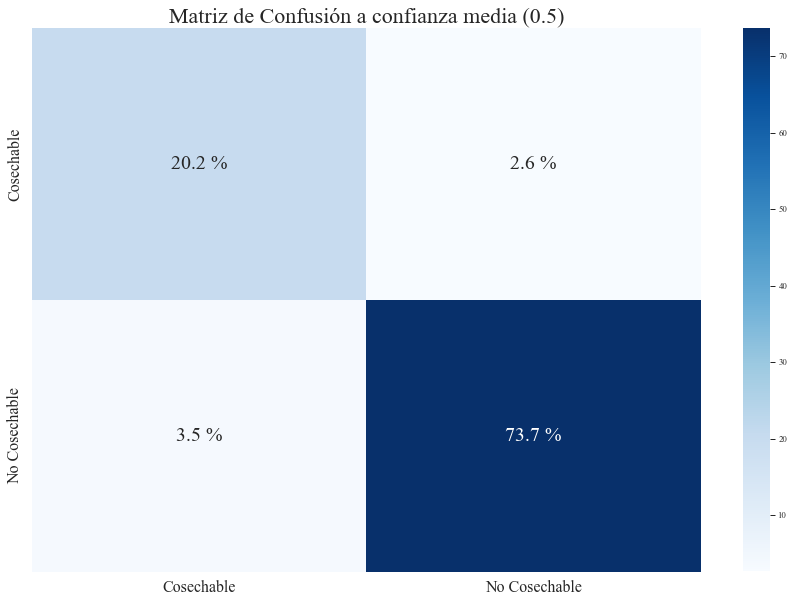

In [138]:
plt.figure(figsize=(15, 10))
ax = sns.heatmap(
    confusion_matrix(y_true, y_pred) * 100 / len(y_pred),
    annot=True,
    cmap="Blues",
    fmt=".1f",
    annot_kws={"fontsize": 20},
    xticklabels=["Cosechable", "No Cosechable"],
    yticklabels=["Cosechable", "No Cosechable"],
)
for t in ax.texts:
    t.set_text(t.get_text() + " %")
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=16)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=16)
ax.set_title("Matriz de Confusión a confianza media (0.5)", fontsize=22);

In [15]:
f1_score(y_true, y_pred)

0.96